Mechanisms through which contamination can cause inferior online learning performance:
1. Predictions for anomalies themselves are wrong (only applies to anomalies in feature space)
2. Anomalous samples don't improve model performance
3. Anomalous samples deteriorate model performance (just more severe version of 2.?)

Techniques to try: 
1. Filtering data stream with anomaly detector
2. Reconstructing samples with autoencoder
3. Classification logit based weighting (weighted by easiness/difficulty/threshold closeness)
4. Autoencoder error based weighting (weighted by easiness/difficulty/threshold closeness) <- proposed technique
5. Classification logit + reconstruction error based weighting

Possible advantages of autoencoder vs. logit based weighting:
1. Can be pre-trained to yield more stability 

Possible disadvantages of autoencoder vs. logit based weighting
1. Blind to label flips (but could use conditional autoencoder)
2. Reconstruction error is only a proxy for downstream difficulty

Scenarios: 
1. Autoencoder: online, Classifier: online
2. Autoencoder: pretrained, Classifier: online
3. Autoencoder: pretrained + online finetuning, Classifier: online <- focus on this? 

Anomaly types: 
1. OOD samples (e.g. sample from held-out class)
2. Random Rotations? (only for image datasets)
3. Feature dropout 
4. Gaussian noise

Datasets: 
1. Insects datasets
2. Forest Cover Type dataset
3. Synthetic streams (Agrawal, RBF)
4. MNIST? May require 

Experiment Steps
1. Split dataset into unlabeled pre-training-dataset, labeled dataset for hyperparameter tuning and data stream for test-then-train eval
2. Optional: Pre-train autoencoder 
3. Tune all hyperparameters on labeled dataset 
4. Remove examples of certain class from data stream (to add back in as anomalies later)
5. Sample indices where to place anomalies (use markov process with states "normal", "anomaly" and different transition probabilities to select indices?)
6. Run prequential evaluation with technique + classifier for modified dataset

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_covtype
import numpy as np
from tqdm import tqdm
from typing import List, Tuple, Callable, Dict, Any
import copy

from src.data.datasets import get_dataset
from src.models.networks import get_mlp, get_autoencoder
import torchvision.transforms as transforms
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

import itertools 


In [7]:
df = pd.read_json("../reports/contamination_rmnist.jsonl", lines=True, orient="records")

df["preds"] = df["preds"].apply(np.array)
df["labels"] = df["labels"].apply(np.array)
df["is_anom"] = df["is_anom"].apply(np.array)

df["accuracy"] = df.apply(
    lambda row: (row["preds"] == row["labels"])[~row["is_anom"]].mean() * 100, axis=1
)
parameters = ["anomaly_type", "p_anomaly", "len_anomaly"]

dfm = df.groupby(parameters)["accuracy"].agg(["mean", "std"])
dfm = dfm.reset_index()


In [9]:
df = pd.read_json("../reports/contamination.jsonl", lines=True, orient="records")

df["preds"] = df["preds"].apply(np.array)
df["labels"] = df["labels"].apply(np.array)
df["is_anom"] = df["is_anom"].apply(np.array)

df["accuracy"] = df.apply(
    lambda row: (row["preds"] == row["labels"])[~row["is_anom"]].mean() * 100, axis=1
)
parameters = ["anomaly_type", "p_anomaly", "len_anomaly"]

dfm = df.groupby(parameters)["accuracy"].agg(["mean", "std"])
dfm = dfm.reset_index()

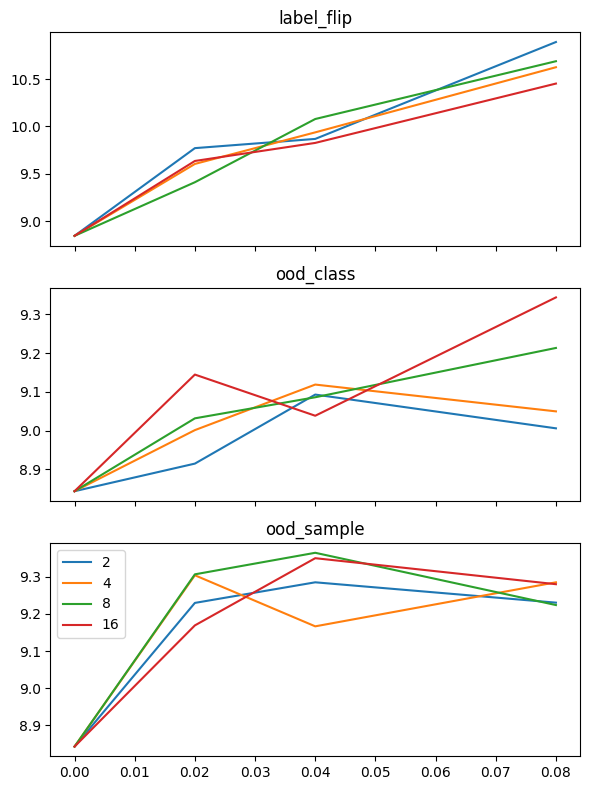

In [10]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 8), sharex=True)

for ax, (anom_type, df_anom_type) in zip(axs, dfm.groupby("anomaly_type")):
    ax.set_title(anom_type)
    for len_anomaly, df_len_anomaly in df_anom_type.groupby("len_anomaly"):
        ax.plot(df_len_anomaly["p_anomaly"], 100-df_len_anomaly["mean"], label=len_anomaly)
        # ax.errorbar(
        #     df_len_anomaly["p_anomaly"],
        #     df_len_anomaly["mean"],
        #     yerr=df_len_anomaly["std"],
        #     fmt="o",
        #     capsize=3,
        # )

ax.legend()
fig.tight_layout()

In [28]:
df = pd.read_json("../reports/tune_full_rmnist.jsonl", orient='records', lines=True)
hparams = ['lr', 'n_hidden_layers', "n_hidden_units"]
df['accuracy'] = df.apply(lambda row: (np.array(row['preds']) == np.array(row['labels'])).mean(), axis=1)
df[hparams + ['accuracy']].sort_values(by='accuracy', ascending=False)

,lr,n_hidden_layers,n_hidden_units,accuracy
95,0.03125,1,1024,0.9192
77,0.03125,1,512,0.9112
59,0.03125,1,256,0.9074
41,0.03125,1,128,0.9018
94,0.06250,1,1024,0.8976
...,...,...,...,...
24,1.00000,2,64,0.1066
54,1.00000,1,256,0.1066
66,1.00000,3,256,0.1066
36,1.00000,1,128,0.1064


In [ ]:
df = pd.read_json("../reports/tune_full2.jsonl", orient='records', lines=True)
hparams = ['lr', 'n_hidden_layers', "n_hidden_units"]
df['accuracy'] = df.apply(lambda row: (np.array(row['preds']) == np.array(row['labels'])).mean(), axis=1)
df[hparams + ['accuracy']].sort_values(by='accuracy', ascending=False)



,lr,n_hidden_layers,n_hidden_units,accuracy
95,0.03125,1,1024,0.7096
77,0.03125,1,512,0.7034
94,0.06250,1,1024,0.7008
101,0.03125,2,1024,0.7008
83,0.03125,2,512,0.6990
...,...,...,...,...
42,1.00000,2,128,0.5914
48,1.00000,3,128,0.5914
54,1.00000,1,256,0.5914
18,1.00000,1,64,0.5912


In [ ]:
def flip_label_random(ys, idcs):
    "Flip labels at idcs to a random other label"
    # TODO: make sure ys_new != ys for all entries or is
    y_unique = np.unique(ys)
    n_flip = len(idcs)
    ys_new = np.random.choice(y_unique, size=n_flip)
    ys[idcs] = ys_new
    return ys


def flip_label_adversarial(ys, idcs, new_label):
    ys[idcs] = new_label
    return ys


# MNIST only
def random_rotation(xs, idcs):
    transform = transforms.RandomRotation(degrees=(-90, -90))
    im_width = int(np.sqrt(xs.shape[-1]))
    xs_transformed = transform(xs[idcs].reshape(-1, im_width, im_width))
    xs[idcs] = xs_transformed.reshape((-1, im_width**2))
    return xs, idcs


def feature_dropout(xs, idcs):
    n_features = xs.shape[-1]
    feature_idcs = np.stack(
        [
            np.random.choice(np.arange(n_features), size=int(0.5 * n_features))
            for _ in range(len(idcs))
        ]
    )
    xs[idcs, feature_idcs] = 0
    return xs


def ood_sample(xs, xs_ood, idcs):
    xs[idcs] = xs_ood

In [39]:
def prep_data(xs, ys, ood_class=0, p_ood=0.05, pre_train_samples=5000, ood_label='random'):
    label_enc = LabelEncoder()
    ood_mask = ys == ood_class
    xs_id, ys_id = xs[~ood_mask], ys[~ood_mask]
    xs_ood = xs[ood_mask]
    scaler = StandardScaler()
    scaler.fit(xs_id[:pre_train_samples])
    xs_id, xs_ood = scaler.transform(xs_id), scaler.transform(xs_ood)

    xs_pre = xs_id[:pre_train_samples]

    xs_post, ys_post = xs_id[pre_train_samples:], ys_id[pre_train_samples:]
    ys_post = label_enc.fit_transform(ys_post)

    n_normal = len(xs_post)

    n_anom = round(n_normal * p_ood / (1-p_ood))
    anom_insert_idcs = np.sort(np.random.choice(np.arange(n_normal), size=n_anom, replace=False))[::-1]
    anom_idcs = np.random.choice(len(xs_ood), size=n_anom, replace=False)
    anoms = xs_ood[anom_idcs]

    xs_contam, ys_contam = xs_post.tolist(), ys_post.tolist()
    for idx, anom in zip(anom_insert_idcs, anoms):
        xs_contam.insert(idx, anom)
        if ood_label == 'random':
            ys_contam.insert(idx, np.random.randint(0, ys_post.max()))
        else:
            ys.contam.insert(idx, ood_label)

    anom_mask = np.ones(len(xs_contam), dtype=bool)   
    anom_mask[anom_insert_idcs] = False

    return xs_pre, np.array(xs_contam), np.array(ys_contam), anom_mask

In [13]:
def pretrain_autoencoder(
    model,
    optimizer_cls,
    data,
    learning_rate,
    loss_fn=F.l1_loss,
    batch_size=32,
    val_split=0.1,
    tolerance_epochs=3,
    device="cpu",
    verbose=True,
):
    # 1. Create dataloader
    n_val = round(val_split * len(data))
    data_train, data_val = data[:-n_val], data[-n_val:]

    train_set = TensorDataset(torch.tensor(data_train, dtype=torch.float))
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    val_set = TensorDataset(torch.tensor(data_val, dtype=torch.float))
    val_loader = DataLoader(val_set, batch_size=batch_size)

    # 2. Initialize Optimizer
    optimizer = optimizer_cls(model.parameters(), lr=learning_rate)
    model.to(device)

    # 3. Training Loop

    best_loss = 1e6
    epochs_since_improvement = 0
    epoch = 0
    best_model = None
    best_model_val_losses = None

    while epochs_since_improvement <= tolerance_epochs:
        # Training
        train_iterator = (
            tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False)
            if verbose
            else train_loader
        )
        model.train()
        for x_batch in train_iterator:
            x_batch = x_batch[0].to(device)

            x_rec = model(x_batch)
            loss = loss_fn(x_rec, x_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation

        model.eval()
        val_losses = []
        for x_batch in val_loader:
            x_batch = x_batch[0].to(device)

            x_rec = model(x_batch)
            loss = loss_fn(x_rec, x_batch)
            val_losses.append(loss.detach().cpu().item())
        mean_val_loss = np.mean(val_losses)
        if mean_val_loss < best_loss:
            epochs_since_improvement = 0
            best_model = copy.deepcopy(model)
            best_loss = mean_val_loss
            best_model_val_losses = val_losses
        else:
            epochs_since_improvement += 1
        epoch += 1

    return best_model, best_model_val_losses

In [ ]:
def train_and_evaluate(
    model: torch.nn.Module,
    train_data: Tuple[np.ndarray, np.ndarray],
    learning_rate: float,
    autoencoder: Callable = None,
    autoencoder_loss_fn: Callable = F.l1_loss,
    loss_weighter: Callable = None,
    batch_size: int = 1,
    label_mask: np.ndarray = None,
    optimizer_cls: Callable[..., torch.optim.Optimizer] = torch.optim.Adam,
    loss_fn: Callable = F.cross_entropy,
    device: str = "cpu",
    verbose: bool = True,
) -> float:
    """
    Trains a model for a single pass over the data and evaluates its accuracy.

    Args:
        model: The PyTorch model to train.
        train_data: A tuple containing training features (X) and labels (y).
        learning_rate: The learning rate for the optimizer.
        batch_size: The number of samples per batch.
        label_mask: A boolean mask to apply to the labels for scoring.
        optimizer_cls: The optimizer class to use (e.g., torch.optim.Adam).
        loss_fn: The loss function to use.
        device: The device to run training on ('cpu' or 'cuda').
        verbose: If True, shows a progress bar.

    Returns:
        The accuracy score.
    """
    # 1. Prepare Data
    features, labels = train_data
    dataset = TensorDataset(torch.tensor(features).float(), torch.tensor(labels).long())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # 2. Initialize Optimizer
    optimizer = optimizer_cls(model.parameters(), lr=learning_rate)
    model.to(device)
    model.train()

    # 3. Training Loop
    all_preds, all_labels = [], []
    iterator = tqdm(dataloader, desc="Training") if verbose else dataloader

    for x_batch, y_batch in iterator:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        if loss_weighter is not None:
            if autoencoder is not None:
                x_rec = autoencoder(x_batch)
                rec_loss = autoencoder_loss_fn(x_rec, x_batch)
                weight = loss_weighter.get_weight(rec_loss.detach())
            else:
                weight = loss_weighter.get_weight(logits.detach(), y_batch.detach())
            loss = loss * weight

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=-1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

    # 4. Calculate final accuracy
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    if label_mask is not None:
        score = (all_preds == all_labels)[label_mask].mean()
    else:
        score = (all_preds == all_labels).mean()

    return float(score)


def run_with_tuning(
    dataset: str,
    classifier_hyperparams: Dict[str, List[Any]],
    autoencoder_hyperparams: Dict[str, List[Any]],  # Now mandatory for AE weighting
    p_ood: float = 0.05,
    device: str = "cpu",
    weight_loss_by: str = "none",
):
    """
    Runs a sequential hyperparameter tuning experiment with a specific order.
    Phase 1: Tunes the classifier independently (no weighting).
    Phase 2: Freezes the best classifier config and tunes the autoencoder to
             maximize the classifier's accuracy.

    Args:
        dataset: The name of the dataset to load.
        classifier_hyperparams: A dictionary of hyperparameters for the classifier.
        autoencoder_hyperparams: A dictionary of hyperparameters for the autoencoder.
        p_ood: The proportion of out-of-distribution data.
        device: The device to run on ('cpu' or 'cuda').
        weight_loss_by: The loss weighting strategy. Must be AE-based for this workflow.
    """
    # Set seed for reproducibility
    np.random.seed(0)
    torch.manual_seed(0)

    # --- Data Preparation ---
    xs, ys = get_dataset(dataset)
    xs_pre, xs_contam, ys_contam, anom_mask = prep_data(
        xs, ys, ood_class=1, p_ood=p_ood, pre_train_samples=5000, ood_label="random"
    )

    n_tune = 1000
    tuning_steps = 2000
    xs_clf_tune, ys_clf_tune = xs_contam[:n_tune], ys_contam[:n_tune]
    xs_stream, ys_stream = xs_contam[n_tune:], ys_contam[n_tune:]
    mask_stream = anom_mask[n_tune:]

    resample_indices = np.random.choice(n_tune, size=tuning_steps, replace=True)
    xs_clf_tune_resampled = xs_clf_tune[resample_indices]
    ys_clf_tune_resampled = ys_clf_tune[resample_indices]

    # --- Phase 1: Tune Classifier (Independently, No Weighting) ---
    print("--- Phase 1: Tuning Classifier Architecture (Independently) ---")
    clf_param_keys = list(classifier_hyperparams.keys())
    clf_param_combinations = list(itertools.product(*classifier_hyperparams.values()))
    clf_tune_results = []

    for combo in tqdm(clf_param_combinations, desc="Classifier Search"):
        config = dict(zip(clf_param_keys, combo))
        model = get_mlp(
            in_features=xs_clf_tune_resampled.shape[-1],
            out_features=ys.max() + 1,
            n_hidden_units=round(
                xs_clf_tune_resampled.shape[-1] * config["hidden_units_factor"]
            ),
            n_hidden_layers=config["n_hidden_layers"],
        )

        # In this phase, we use NO weighter to find the best raw classifier.
        score = train_and_evaluate(
            model=model,
            train_data=(xs_clf_tune_resampled, ys_clf_tune_resampled),
            learning_rate=config["learning_rate"],
            batch_size=1,
            device=device,
            verbose=False,
            loss_weighter=None,
            autoencoder=None,
        )
        config["accuracy"] = score
        clf_tune_results.append(config)

    best_classifier_config = max(clf_tune_results, key=lambda x: x["accuracy"])
    print(
        f"\nBest Independent Classifier Config Found (Accuracy: {best_classifier_config['accuracy']:.4f}): {best_classifier_config}"
    )

    # --- Phase 2: Tune Autoencoder (To Maximize Classifier Accuracy) ---
    # This phase only runs if an AE-based weighter is selected.
    use_autoencoder_weighter = (
        weight_loss_by != "none" and autoencoder_hyperparams is not None
    )
    if not use_autoencoder_weighter:
        print("\nSkipping Autoencoder tuning as no AE-based weighter is selected.")
        # If no AE is used, the best model is simply the one from Phase 1
        best_autoencoder_config = None
    else:
        print(
            "\n--- Phase 2: Tuning Autoencoder to Maximize Classifier Performance ---"
        )
        ae_param_keys = list(autoencoder_hyperparams.keys())
        ae_param_combinations = list(
            itertools.product(*autoencoder_hyperparams.values())
        )
        ae_tune_results = []

        for combo in tqdm(ae_param_combinations, desc="Autoencoder Search"):
            ae_config = dict(zip(ae_param_keys, combo))

            # 1. Train an AE with the current hyperparameter combination
            autoencoder = get_autoencoder(
                in_features=xs_pre.shape[-1],
                compression=ae_config["compression"],
                dropout=ae_config["dropout"],
                n_hidden_layers=ae_config["n_hidden_layers"],
            )
            autoencoder, _ = pretrain_autoencoder(
                autoencoder,
                ae_config["optimizer_cls"],
                xs_pre,
                ae_config["learning_rate"],
                verbose=False,
            )

            # 2. Instantiate the BEST classifier from Phase 1 (fresh weights)
            classifier_for_ae_tuning = get_mlp(
                in_features=xs_clf_tune_resampled.shape[-1],
                out_features=ys.max() + 1,
                n_hidden_units=round(
                    xs_clf_tune_resampled.shape[-1]
                    * best_classifier_config["hidden_units_factor"]
                ),
                n_hidden_layers=best_classifier_config["n_hidden_layers"],
            )

            # 3. Evaluate the COMBINATION on the tuning set
            loss_weighter = AutoencoderBasedWeighter(weight_by=weight_loss_by)
            score = train_and_evaluate(
                model=classifier_for_ae_tuning,
                train_data=(xs_clf_tune_resampled, ys_clf_tune_resampled),
                learning_rate=best_classifier_config[
                    "learning_rate"
                ],  # Use best LR from Phase 1
                batch_size=1,
                device=device,
                verbose=False,
                loss_weighter=loss_weighter,
                autoencoder=autoencoder,
            )

            ae_config["classifier_accuracy"] = score
            ae_tune_results.append(ae_config)

        best_autoencoder_config = max(
            ae_tune_results, key=lambda x: x["classifier_accuracy"]
        )
        print(
            f"\nBest AE Config Found (Yielded Classifier Accuracy: {best_autoencoder_config['classifier_accuracy']:.4f}): {best_autoencoder_config}"
        )

    # --- Phase 3: Final Evaluation on the Stream ---
    print("\n--- Phase 3: Evaluating best model combination on the data stream ---")

    # Instantiate final classifier with best architecture
    final_model = get_mlp(
        in_features=xs_stream.shape[-1],
        out_features=ys.max() + 1,
        n_hidden_units=round(
            xs_stream.shape[-1] * best_classifier_config["hidden_units_factor"]
        ),
        n_hidden_layers=best_classifier_config["n_hidden_layers"],
    )

    # Instantiate and train final autoencoder with best architecture
    final_autoencoder = None
    final_weighter = None
    if use_autoencoder_weighter:
        final_autoencoder = get_autoencoder(
            in_features=xs_pre.shape[-1],
            compression=best_autoencoder_config["compression"],
            dropout=best_autoencoder_config["dropout"],
            n_hidden_layers=best_autoencoder_config["n_hidden_layers"],
        )
        print("Training Autoencoder")
        final_autoencoder, _ = pretrain_autoencoder(
            final_autoencoder,
            best_autoencoder_config["optimizer_cls"],
            xs_pre,
            best_autoencoder_config["learning_rate"],
        )
        final_weighter = AutoencoderBasedWeighter(weight_by=weight_loss_by)

    print("Running Classification")
    stream_score = train_and_evaluate(
        model=final_model,
        train_data=(xs_stream, ys_stream),
        learning_rate=best_classifier_config["learning_rate"],
        batch_size=1,
        label_mask=mask_stream,
        loss_weighter=final_weighter,
        autoencoder=final_autoencoder,
        device=device,
    )

    print(f"\nFinal Stream Accuracy with Sequentially Tuned Models: {stream_score:.4f}")
    return stream_score

In [15]:
hyperparams_classifier = dict(
    learning_rate=[1e-3, 2e-3, 4e-3],
    hidden_units_factor=[1.0, 2.0, 4.0],
    n_hidden_layers=[1, 2],
)

hyperparams_autoencoder = dict(
    learning_rate=[1e-3, 2e-3, 4e-3],
    compression=[0.25, 0.5, 1.0],
    n_hidden_layers=[1, 2],
    dropout=[.2],
    optimizer_cls=[torch.optim.Adam]
)

p_oods = [0.04, 0.08]
dataset = "Covertype"

results = []
for p_ood in p_oods:
    score = run_with_tuning(
        dataset="Covertype",
        classifier_hyperparams=hyperparams_classifier,
        autoencoder_hyperparams=hyperparams_autoencoder,
        p_ood=p_ood,
        weight_loss_by="easiness",
    )
    results.append({"p_ood": p_ood, "accuracy": score})


--- Phase 1: Tuning Classifier Architecture (Independently) ---


Classifier Search: 100%|██████████| 18/18 [00:16<00:00,  1.12it/s]



Best Independent Classifier Config Found (Accuracy: 0.7310): {'learning_rate': 0.002, 'hidden_units_factor': 4.0, 'n_hidden_layers': 1, 'accuracy': 0.731}

--- Phase 2: Tuning Autoencoder to Maximize Classifier Performance ---


Autoencoder Search: 100%|██████████| 18/18 [01:17<00:00,  4.30s/it]



Best AE Config Found (Yielded Classifier Accuracy: 0.7360): {'learning_rate': 0.002, 'compression': 0.25, 'n_hidden_layers': 2, 'dropout': 0.2, 'optimizer_cls': <class 'torch.optim.adam.Adam'>, 'classifier_accuracy': 0.736}

--- Phase 3: Evaluating best model combination on the data stream ---
Training Autoencoder


Running Classification


Training: 100%|██████████| 75015/75015 [00:46<00:00, 1630.50it/s]



Final Stream Accuracy with Sequentially Tuned Models: 0.9407
--- Phase 1: Tuning Classifier Architecture (Independently) ---


Classifier Search: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]



Best Independent Classifier Config Found (Accuracy: 0.7155): {'learning_rate': 0.002, 'hidden_units_factor': 4.0, 'n_hidden_layers': 1, 'accuracy': 0.7155}

--- Phase 2: Tuning Autoencoder to Maximize Classifier Performance ---


Autoencoder Search: 100%|██████████| 18/18 [01:16<00:00,  4.28s/it]



Best AE Config Found (Yielded Classifier Accuracy: 0.7150): {'learning_rate': 0.002, 'compression': 1.0, 'n_hidden_layers': 1, 'dropout': 0.2, 'optimizer_cls': <class 'torch.optim.adam.Adam'>, 'classifier_accuracy': 0.715}

--- Phase 3: Evaluating best model combination on the data stream ---
Training Autoencoder


Running Classification


Training: 100%|██████████| 78320/78320 [00:45<00:00, 1717.05it/s]



Final Stream Accuracy with Sequentially Tuned Models: 0.9071


In [ ]:
np.random.seed(0)
torch.manual_seed(0)
weight_loss_by = 'easiness'

# --- Data Preparation ---
xs, ys = get_dataset(dataset)
xs_pre, xs_contam, ys_contam, anom_mask = prep_data(
    xs, ys, ood_class=1, p_ood=p_ood, pre_train_samples=5000, ood_label="random"
)

n_tune = 1000
tuning_steps = 2000
xs_clf_tune, ys_clf_tune = xs_contam[:n_tune], ys_contam[:n_tune]
xs_stream, ys_stream = xs_contam[n_tune:], ys_contam[n_tune:]
mask_stream = anom_mask[n_tune:]

resample_indices = np.random.choice(n_tune, size=tuning_steps, replace=True)
xs_clf_tune_resampled = xs_clf_tune[resample_indices]
ys_clf_tune_resampled = ys_clf_tune[resample_indices]

# --- Phase 1: Tune Classifier (Independently, No Weighting) ---
print("--- Phase 1: Tuning Classifier Architecture (Independently) ---")
clf_param_keys = list(hyperparams_classifier.keys())
clf_param_combinations = list(itertools.product(*hyperparams_classifier.values()))
clf_tune_results = []

for combo in tqdm(clf_param_combinations, desc="Classifier Search"):
    config = dict(zip(clf_param_keys, combo))
    model = get_mlp(
        in_features=xs_clf_tune_resampled.shape[-1],
        out_features=ys.max() + 1,
        n_hidden_units=round(
            xs_clf_tune_resampled.shape[-1] * config["hidden_units_factor"]
        ),
        n_hidden_layers=config["n_hidden_layers"],
    )

    # In this phase, we use NO weighter to find the best raw classifier.
    score = train_and_evaluate(
        model=model,
        train_data=(xs_clf_tune_resampled, ys_clf_tune_resampled),
        learning_rate=config["learning_rate"],
        batch_size=1,
        device="cpu",
        verbose=False,
        loss_weighter=None,
        autoencoder=None,
    )
    config["accuracy"] = score
    clf_tune_results.append(config)

best_classifier_config = max(clf_tune_results, key=lambda x: x["accuracy"])
print(
    f"\nBest Independent Classifier Config Found (Accuracy: {best_classifier_config['accuracy']:.4f}): {best_classifier_config}"
)

# --- Phase 2: Tune Autoencoder (To Maximize Classifier Accuracy) ---
# This phase only runs if an AE-based weighter is selected.

print("\n--- Phase 2: Tuning Autoencoder to Maximize Classifier Performance ---")
ae_param_keys = list(hyperparams_autoencoder.keys())
ae_param_combinations = list(itertools.product(*hyperparams_autoencoder.values()))
ae_tune_results = []

for combo in tqdm(ae_param_combinations, desc="Autoencoder Search"):
    ae_config = dict(zip(ae_param_keys, combo))

    # 1. Train an AE with the current hyperparameter combination
    autoencoder = get_autoencoder(
        in_features=xs_pre.shape[-1],
        compression=ae_config["compression"],
        dropout=ae_config["dropout"],
        n_hidden_layers=ae_config["n_hidden_layers"],
    )
    autoencoder, _ = pretrain_autoencoder(
        autoencoder,
        ae_config["optimizer_cls"],
        xs_pre,
        ae_config["learning_rate"],
        verbose=False,
    )
    # 2. Instantiate the BEST classifier from Phase 1 (fresh weights)
    classifier_for_ae_tuning = get_mlp(
        in_features=xs_clf_tune_resampled.shape[-1],
        out_features=ys.max() + 1,
        n_hidden_units=round(
            xs_clf_tune_resampled.shape[-1]
            * best_classifier_config["hidden_units_factor"]
        ),
        n_hidden_layers=best_classifier_config["n_hidden_layers"],
    )

    # 3. Evaluate the COMBINATION on the tuning set
    loss_weighter = AutoencoderBasedWeighter(weight_by=weight_loss_by)
    score = train_and_evaluate(
        model=classifier_for_ae_tuning,
        train_data=(xs_clf_tune_resampled, ys_clf_tune_resampled),
        learning_rate=best_classifier_config[
            "learning_rate"
        ],  # Use best LR from Phase 1
        batch_size=1,
        device='cpu',
        verbose=False,
        loss_weighter=loss_weighter,
        autoencoder=autoencoder,
    )

    ae_config["classifier_accuracy"] = score
    ae_tune_results.append(ae_config)

best_autoencoder_config = max(ae_tune_results, key=lambda x: x["classifier_accuracy"])

autoenc = get_autoencoder(
    in_features=xs_pre.shape[-1],
    compression=best_autoencoder_config["compression"],
    dropout=best_autoencoder_config["dropout"],
    n_hidden_layers=best_autoencoder_config["n_hidden_layers"],
)
print("Training Autoencoder")
autoenc, _ = pretrain_autoencoder(
    autoenc,
    best_autoencoder_config["optimizer_cls"],
    xs_pre,
    best_autoencoder_config["learning_rate"],
)

stream_data = TensorDataset(torch.tensor(xs_stream, dtype=torch.float))
stream_loader = DataLoader(stream_data, batch_size=1, shuffle=False)

rec_losses = []
for batch in tqdm(stream_loader):
    x = batch[0]
    x_rec = autoenc(x)
    rec_losses.append(F.l1_loss(x, x_rec).detach().item())


--- Phase 1: Tuning Classifier Architecture (Independently) ---


Classifier Search: 100%|██████████| 18/18 [00:16<00:00,  1.10it/s]



Best Independent Classifier Config Found (Accuracy: 0.7155): {'learning_rate': 0.002, 'hidden_units_factor': 4.0, 'n_hidden_layers': 1, 'accuracy': 0.7155}

--- Phase 2: Tuning Autoencoder to Maximize Classifier Performance ---


Autoencoder Search: 100%|██████████| 18/18 [01:18<00:00,  4.38s/it]


Training Autoencoder


100%|██████████| 78320/78320 [00:09<00:00, 8187.55it/s]               


In [ ]:
from sklearn.metrics import roc_auc_score

In [34]:
xs, ys = get_dataset(dataset)
xs_pre, xs_contam, ys_contam, anom_mask = prep_data(
    xs, ys, ood_class=1, p_ood=0.02, pre_train_samples=5000, ood_label="random"
)

autoenc = get_autoencoder(
    in_features=xs_pre.shape[-1],
    compression=1.0,
    dropout=0.0,
    n_hidden_layers=1,
)
# print("Training Autoencoder")
# autoenc, _ = pretrain_autoencoder(
    # autoenc,
    # torch.optim.Adam,
    # xs_pre,
    # 1e-3,
# )

stream_data = TensorDataset(torch.tensor(xs_contam, dtype=torch.float))
stream_loader = DataLoader(stream_data, batch_size=1, shuffle=False)

optim = torch.optim.Adam(autoenc.parameters(), lr=1e-3)

rec_losses = []
for batch in tqdm(stream_loader):
    autoenc.eval()
    x = batch[0]
    x_rec = autoenc(x)
    rec_losses.append(F.l1_loss(x, x_rec).detach().item())

    autoenc.train()
    x_rec = autoenc(x)
    loss = F.l1_loss(x, x_rec)

    loss.backward()
    optim.step()
    optim.zero_grad()


rec_losses = np.array(rec_losses)
roc_auc_score(~anom_mask, rec_losses)

100%|██████████| 74463/74463 [00:56<00:00, 1306.86it/s]


0.502463935424124

In [13]:
xs, ys = get_dataset("Rotated MNIST")
label_enc = LabelEncoder()
ys = label_enc.fit_transform(ys)
y_ood = 0

ood_mask = ys == y_ood
ys[ood_mask]


array([0, 0, 0, ..., 0, 0, 0], shape=(9972,))

In [15]:
xs_clean = xs[~ood_mask]
ys_clean = ys[~ood_mask]
xs_ood = xs[ood_mask]
p_ood = .01

n_normal = len(xs_clean)
n_anom = round(n_normal * p_ood / (1 - p_ood))
anom_insert_idcs = np.sort(
    np.random.choice(np.arange(n_normal), size=n_anom, replace=False)
)[::-1]
anom_idcs = np.random.choice(len(xs_ood), size=n_anom, replace=False)
anoms = xs_ood[anom_idcs]

xs_contam, ys_contam = xs_clean.tolist(), ys_clean.tolist()
for idx, anom in zip(anom_insert_idcs, anoms):
    xs_contam.insert(idx, anom)
    ys_contam.insert(idx, 0)

xs_contam = np.array(xs_contam)
ys_contam = np.array(ys_contam)

anom_mask = np.ones(len(xs_contam), dtype=bool)   
anom_mask[anom_insert_idcs] = False

In [16]:
from sklearn.ensemble import IsolationForest

model = IsolationForest()
model.fit(xs_contam)
scores = model.score_samples(xs_contam)
roc_auc_score(~anom_mask, scores)

0.48138334960256596

In [22]:
ys_contam[anom_insert_idcs-1]

array([8, 2, 7, 2, 1, 6, 2, 4, 4, 3, 5, 2, 7, 2, 1, 6, 3, 9, 1, 2, 7, 9,
       6, 2, 5, 1, 4, 2, 4, 2, 4, 1, 6, 3, 1, 1, 7, 2, 6, 4, 5, 8, 7, 7,
       4, 4, 2, 3, 9, 2, 4, 9, 1, 7, 9, 4, 6, 7, 5, 7, 7, 4, 3, 2, 5, 9,
       9, 1, 9, 3, 7, 8, 5, 1, 8, 8, 6, 3, 7, 2, 1, 2, 1, 6, 7, 7, 6, 8,
       4, 3, 4, 8, 9, 2, 9, 6, 3, 8, 2, 6, 2, 8, 5, 4, 8, 8, 5, 9, 8, 1,
       5, 4, 9, 6, 2, 1, 7, 6, 7, 4, 3, 8, 4, 2, 9, 3, 8, 3, 7, 1, 9, 8,
       1, 4, 1, 7, 3, 0, 4, 1, 7, 4, 7, 2, 5, 3, 4, 2, 9, 5, 3, 5, 7, 2,
       4, 2, 9, 2, 7, 9, 5, 9, 1, 4, 2, 7, 9, 1, 9, 7, 3, 4, 4, 7, 2, 5,
       1, 7, 2, 9, 1, 2, 6, 8, 1, 9, 2, 7, 6, 1, 7, 8, 4, 2, 7, 5, 8, 6,
       6, 8, 1, 3, 8, 9, 5, 4, 7, 1, 7, 5, 9, 4, 3, 2, 7, 5, 1, 9, 8, 5,
       6, 6, 7, 4, 5, 5, 7, 1, 1, 6, 1, 6, 7, 4, 9, 8, 9, 8, 7, 9, 7, 9,
       6, 3, 5, 7, 1, 1, 1, 7, 2, 3, 7, 1, 8, 5, 4, 8, 7, 8, 9, 3, 9, 6,
       7, 8, 7, 5, 4, 7, 6, 4, 5, 9, 2, 9, 6, 5, 2, 5, 8, 6, 3, 3, 5, 1,
       8, 1, 7, 9, 2, 8, 3, 5, 8, 9, 5, 9, 5, 5, 5,

Final Stream Accuracy: 0.9581

Final Stream Accuracy: 0.9412

Final Stream Accuracy: 0.9078